# MCMC for Phylogenetic Trees: Convergence Analysis

This notebook demonstrates MCMC sampling for phylogenetic trees under the Kingman coalescent prior with Jukes-Cantor sequence evolution.

**Key Components:**
- Tree topology moves (SPR - Subtree Pruning and Regrafting)
- Node time resampling from the coalescent prior
- Mutation rate inference with log-normal proposals

**Convergence Diagnostics:**
- Multiple independent chains
- Gelman-Rubin R-hat statistic
- Effective Sample Size (ESS)
- Trace plots and posterior distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from mcmc import kingman_mcmc
from recorder import Recorder
from tree import Tree, coalescence_tree_with_sequences

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

## Helper Functions

In [2]:
def calculate_ess(samples):
    """Effective Sample Size using autocorrelation method."""
    n = len(samples)
    if n < 10:
        return n
    
    samples = np.asarray(samples)
    mean = np.mean(samples)
    var = np.var(samples)
    if var == 0:
        return n
    
    # Compute autocorrelation
    max_lag = min(n - 1, 1000)
    acf_sum = 0.0
    for lag in range(1, max_lag):
        acf = np.mean((samples[:-lag] - mean) * (samples[lag:] - mean)) / var
        if acf < 0.05:  # Stop when autocorrelation drops below threshold
            break
        acf_sum += acf
    
    return n / (1 + 2 * acf_sum)


def calculate_rhat(chains):
    """Gelman-Rubin R-hat statistic for convergence."""
    m = len(chains)  # Number of chains
    n = len(chains[0])  # Length of each chain
    
    chain_means = [np.mean(chain) for chain in chains]
    chain_vars = [np.var(chain, ddof=1) for chain in chains]
    
    overall_mean = np.mean(chain_means)
    B = n * np.var(chain_means, ddof=1)  # Between-chain variance
    W = np.mean(chain_vars)  # Within-chain variance
    
    var_estimate = ((n - 1) / n) * W + (1 / n) * B
    
    if W == 0:
        return float('inf')
    return np.sqrt(var_estimate / W)

In [3]:
def run_mcmc_chains(sample_size, seq_length, mutation_rate, n_chains=3, 
                    steps=1000, step_size=0.3, burnin_frac=0.2):
    """
    Run multiple MCMC chains and return results.
    
    Parameters
    ----------
    sample_size : int
        Number of taxa in the tree
    seq_length : int
        Length of DNA sequences
    mutation_rate : float
        True mutation rate used for simulation
    n_chains : int
        Number of independent chains
    steps : int
        MCMC iterations per chain
    step_size : float
        Proposal step size for mutation rate
    burnin_frac : float
        Fraction of samples to discard as burn-in
    """
    results = {
        'chains': [],
        'params': {
            'sample_size': sample_size,
            'seq_length': seq_length,
            'true_mutation_rate': mutation_rate,
            'steps': steps,
            'step_size': step_size
        }
    }
    
    pi = np.array([0.5, 0.5])  # Binary sequences
    
    for i in range(n_chains):
        # Generate data
        tree, sequences = coalescence_tree_with_sequences(
            sample_size, 2, seq_length, mutation_rate
        )
        tree.sequences = sequences
        
        # Run MCMC
        recorder = Recorder(sample_size, seq_length)
        acceptance = kingman_mcmc(tree, recorder, pi, steps=steps, step_size=step_size)
        
        # Store results (after burn-in)
        burnin = int(steps * burnin_frac)
        results['chains'].append({
            'mutation_rates': np.array(recorder.mutation_rates[burnin:]),
            'log_likelihoods': np.array(recorder.log_likelihoods[burnin:]),
            'acceptance': acceptance,
            'full_rates': np.array(recorder.mutation_rates)
        })
        
        print(f"Chain {i+1}: Accept rates - SPR={acceptance[0]:.2f}, Times={acceptance[1]:.2f}, Mutation={acceptance[2]:.2f}")
    
    return results

## Run MCMC Analysis

We run 3 independent chains to assess convergence using the Gelman-Rubin diagnostic.

In [4]:
# Configuration
SAMPLE_SIZE = 8       # Number of taxa
SEQ_LENGTH = 100      # Sequence length (longer = more information)
TRUE_MU = 1.0         # True mutation rate
N_CHAINS = 3          # Independent chains
STEPS = 2000          # MCMC iterations
STEP_SIZE = 0.5       # Mutation rate proposal step size

print(f"Running {N_CHAINS} MCMC chains with {STEPS} steps each...")
print(f"Data: {SAMPLE_SIZE} taxa, {SEQ_LENGTH}bp sequences, true μ = {TRUE_MU}\n")

results = run_mcmc_chains(
    sample_size=SAMPLE_SIZE,
    seq_length=SEQ_LENGTH,
    mutation_rate=TRUE_MU,
    n_chains=N_CHAINS,
    steps=STEPS,
    step_size=STEP_SIZE
)

Running 3 MCMC chains with 2000 steps each...
Data: 8 taxa, 100bp sequences, true μ = 1.0

Step 1/2000: Mutation Rate = 1.1760, Log Likelihood = -447.3437, Acceptance Rates - SPR: 0.00, Times: 0.00, Mutations: 1.00
Step 10/2000: Mutation Rate = 1.3231, Log Likelihood = -155.4575, Acceptance Rates - SPR: 0.30, Times: 0.10, Mutations: 0.50
Step 20/2000: Mutation Rate = 5.1856, Log Likelihood = -137.6658, Acceptance Rates - SPR: 0.25, Times: 0.15, Mutations: 0.55
Step 30/2000: Mutation Rate = 4.4983, Log Likelihood = -137.8548, Acceptance Rates - SPR: 0.23, Times: 0.10, Mutations: 0.50
Step 40/2000: Mutation Rate = 4.9022, Log Likelihood = -137.7143, Acceptance Rates - SPR: 0.20, Times: 0.07, Mutations: 0.50
Step 50/2000: Mutation Rate = 4.9226, Log Likelihood = -135.2558, Acceptance Rates - SPR: 0.28, Times: 0.10, Mutations: 0.54
Step 60/2000: Mutation Rate = 2.4240, Log Likelihood = -134.0717, Acceptance Rates - SPR: 0.25, Times: 0.12, Mutations: 0.55
Step 70/2000: Mutation Rate = 1.448

## Convergence Diagnostics

In [5]:
# Calculate diagnostics
all_rates = [c['mutation_rates'] for c in results['chains']]
rhat = calculate_rhat(all_rates)
ess_values = [calculate_ess(rates) for rates in all_rates]

print("=" * 50)
print("CONVERGENCE DIAGNOSTICS")
print("=" * 50)
print(f"R-hat (Gelman-Rubin): {rhat:.3f}")
print(f"  - Target: < 1.1 indicates convergence")
print(f"  - Status: {'CONVERGED' if rhat < 1.1 else 'NOT CONVERGED'}")
print()
print(f"Effective Sample Size (ESS):")
for i, ess in enumerate(ess_values):
    print(f"  Chain {i+1}: {ess:.0f} / {len(all_rates[i])} ({100*ess/len(all_rates[i]):.1f}%)")
print("=" * 50)

CONVERGENCE DIAGNOSTICS
R-hat (Gelman-Rubin): 1.152
  - Target: < 1.1 indicates convergence
  - Status: NOT CONVERGED

Effective Sample Size (ESS):
  Chain 1: 74 / 1600 (4.7%)
  Chain 2: 115 / 1600 (7.2%)
  Chain 3: 87 / 1600 (5.4%)


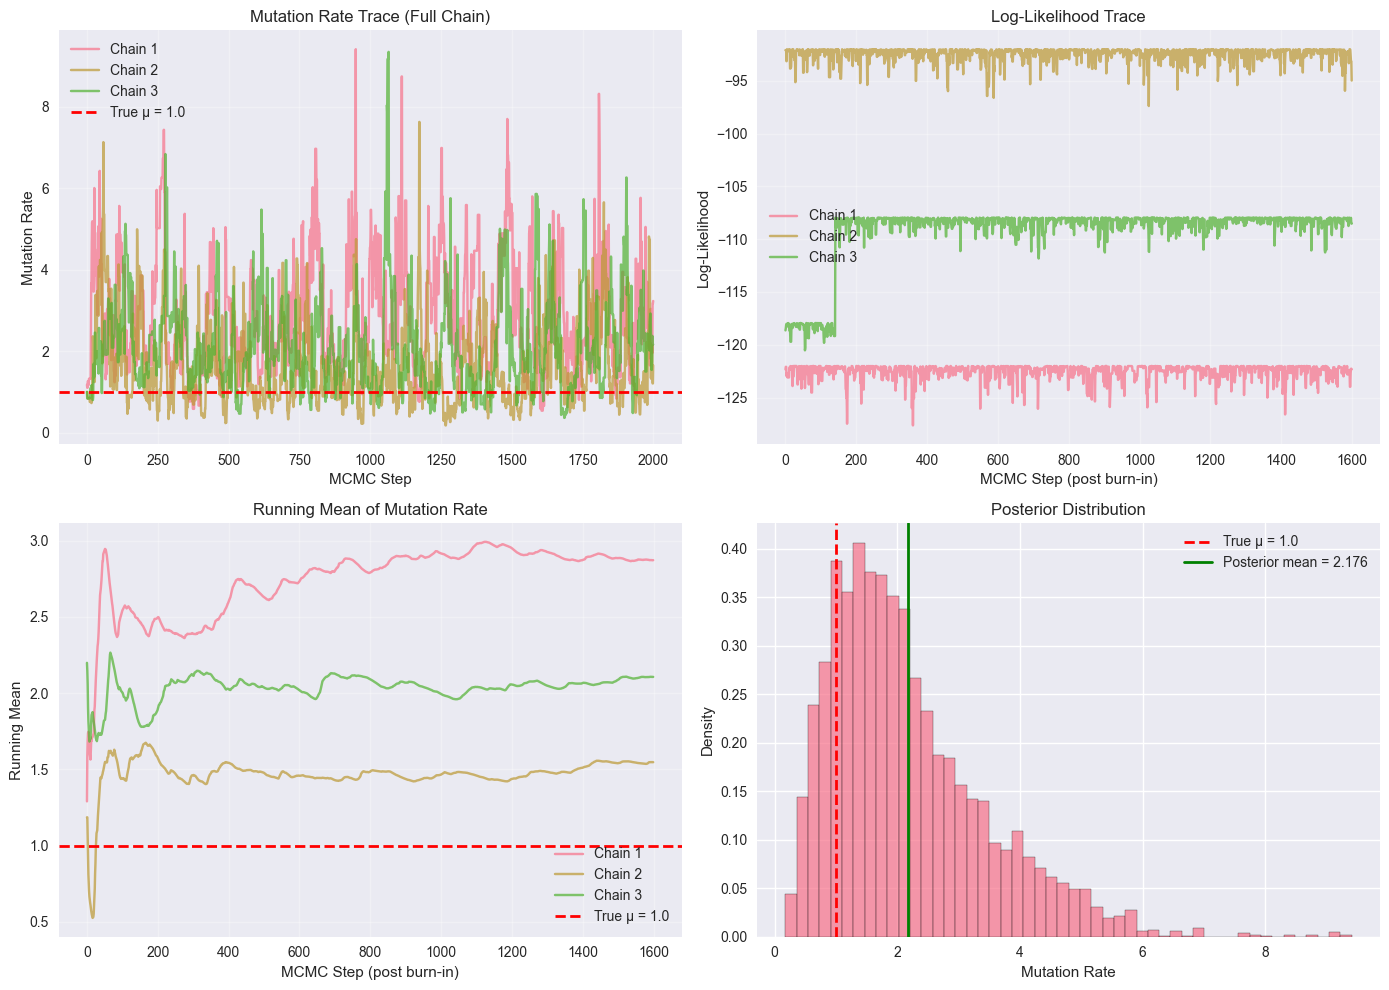

In [6]:
# Trace plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mutation rate traces (full chain)
ax = axes[0, 0]
for i, chain in enumerate(results['chains']):
    ax.plot(chain['full_rates'], alpha=0.7, label=f'Chain {i+1}')
ax.axhline(TRUE_MU, color='red', linestyle='--', linewidth=2, label=f'True μ = {TRUE_MU}')
ax.set_xlabel('MCMC Step')
ax.set_ylabel('Mutation Rate')
ax.set_title('Mutation Rate Trace (Full Chain)')
ax.legend()
ax.grid(True, alpha=0.3)

# Log-likelihood traces
ax = axes[0, 1]
for i, chain in enumerate(results['chains']):
    ax.plot(chain['log_likelihoods'], alpha=0.7, label=f'Chain {i+1}')
ax.set_xlabel('MCMC Step (post burn-in)')
ax.set_ylabel('Log-Likelihood')
ax.set_title('Log-Likelihood Trace')
ax.legend()
ax.grid(True, alpha=0.3)

# Running mean
ax = axes[1, 0]
for i, chain in enumerate(results['chains']):
    running_mean = np.cumsum(chain['mutation_rates']) / np.arange(1, len(chain['mutation_rates']) + 1)
    ax.plot(running_mean, alpha=0.7, label=f'Chain {i+1}')
ax.axhline(TRUE_MU, color='red', linestyle='--', linewidth=2, label=f'True μ = {TRUE_MU}')
ax.set_xlabel('MCMC Step (post burn-in)')
ax.set_ylabel('Running Mean')
ax.set_title('Running Mean of Mutation Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# Posterior distribution
ax = axes[1, 1]
combined_rates = np.concatenate(all_rates)
ax.hist(combined_rates, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.axvline(TRUE_MU, color='red', linestyle='--', linewidth=2, label=f'True μ = {TRUE_MU}')
ax.axvline(np.mean(combined_rates), color='green', linestyle='-', linewidth=2, 
           label=f'Posterior mean = {np.mean(combined_rates):.3f}')
ax.set_xlabel('Mutation Rate')
ax.set_ylabel('Density')
ax.set_title('Posterior Distribution')
ax.legend()

plt.tight_layout()
plt.show()

## Posterior Summary

In [7]:
combined_rates = np.concatenate(all_rates)

print("=" * 50)
print("POSTERIOR SUMMARY: Mutation Rate")
print("=" * 50)
print(f"True value:         {TRUE_MU:.4f}")
print(f"Posterior mean:     {np.mean(combined_rates):.4f}")
print(f"Posterior median:   {np.median(combined_rates):.4f}")
print(f"Posterior std:      {np.std(combined_rates):.4f}")
print(f"95% CI:             [{np.percentile(combined_rates, 2.5):.4f}, {np.percentile(combined_rates, 97.5):.4f}]")
print()
print(f"True value in 95% CI: {np.percentile(combined_rates, 2.5) <= TRUE_MU <= np.percentile(combined_rates, 97.5)}")
print("=" * 50)

POSTERIOR SUMMARY: Mutation Rate
True value:         1.0000
Posterior mean:     2.1756
Posterior median:   1.8811
Posterior std:      1.2842
95% CI:             [0.4988, 5.2371]

True value in 95% CI: True


## Acceptance Rate Analysis

Optimal acceptance rates:
- **SPR moves**: 20-40% (topology changes are often rejected)
- **Time resampling**: 30-50% (from coalescent prior)
- **Mutation rate**: 20-50% (adjust `step_size` if too high/low)

In [8]:
print("ACCEPTANCE RATES BY CHAIN")
print("-" * 50)
print(f"{'Chain':<8} {'SPR':<12} {'Times':<12} {'Mutation':<12}")
print("-" * 50)

for i, chain in enumerate(results['chains']):
    acc = chain['acceptance']
    print(f"{i+1:<8} {acc[0]:<12.3f} {acc[1]:<12.3f} {acc[2]:<12.3f}")

print("-" * 50)
print(f"{'Optimal':<8} {'20-40%':<12} {'30-50%':<12} {'20-50%':<12}")

ACCEPTANCE RATES BY CHAIN
--------------------------------------------------
Chain    SPR          Times        Mutation    
--------------------------------------------------
1        0.346        0.245        0.476       
2        0.364        0.363        0.609       
3        0.367        0.263        0.514       
--------------------------------------------------
Optimal  20-40%       30-50%       20-50%      


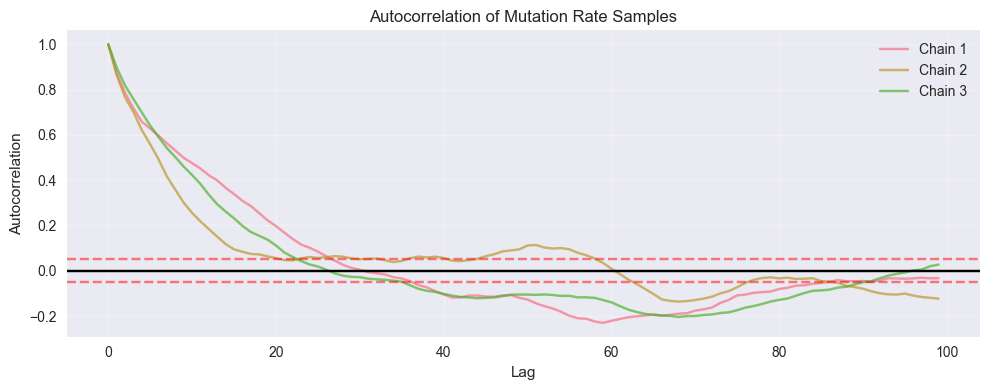


Note: High autocorrelation indicates the chain is moving slowly.
Consider thinning or running longer to get more independent samples.


In [ ]:
# Autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 4))

max_lag = 100
for i, rates in enumerate(all_rates):
    acf = []
    mean = np.mean(rates)
    var = np.var(rates)
    for lag in range(max_lag):
        if lag == 0:
            acf.append(1.0)
        else:
            acf.append(np.mean((rates[:-lag] - mean) * (rates[lag:] - mean)) / var)
    ax.plot(acf, alpha=0.7, label=f'Chain {i+1}')

ax.axhline(0, color='black', linestyle='-')
ax.axhline(0.05, color='red', linestyle='--', alpha=0.5)
ax.axhline(-0.05, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of Mutation Rate Samples')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

